In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [45]:
import math

def format_value_with_uncertainty(value, variance, sample_size):
    def round_to_one_significant(x):
        if x == 0:
            return 0.0
        exponent = np.floor(np.log10(abs(x)))
        mantissa = x / (10 ** exponent)
        rounded_mantissa = np.round(mantissa)
        if rounded_mantissa == 10:
            rounded_mantissa = 1
            exponent += 1
        return rounded_mantissa * (10 ** exponent)
    
    def get_decimal_places(x):
        s = "{0:.10f}".format(x).rstrip('0').rstrip('.')
        return len(s.split('.')[1]) if '.' in s else 0
    
    std_dev = np.sqrt(variance)
    standard_error = std_dev / np.sqrt(sample_size)
    
    if standard_error == 0:
        return f"{round(value):.0f} ± 0"
    
    rounded_uncertainty = round_to_one_significant(standard_error)
    decimal_places = get_decimal_places(rounded_uncertainty)
    
    formatted_value = round(value, decimal_places)
    formatted_uncertainty = round(rounded_uncertainty, decimal_places)
    
    return f"{formatted_value:.{decimal_places}f} ± {formatted_uncertainty:.{decimal_places}f}"

In [7]:
def print_hist_dencity(dist, plot_range, save_path):
    a = dict()
    a[10] = dist.rvs(10)
    a[50] = dist.rvs(50)
    a[1000] = dist.rvs(1000)
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    for num, ax in zip(a.keys(), axes):
        ax.set_title(f'Number of samples {num}')
        if isinstance(dist.dist, stats.rv_continuous):
            ax.hist(a[num], bins=np.sqrt(num).astype(int), range=plot_range, density=True, color='blue', alpha=0.5)
            x = np.linspace(plot_range[0], plot_range[1], num=int(1e5))
            ax.plot(x, dist.pdf(x), color='red')
        else:
            x = np.arange(plot_range[0], plot_range[1])
            ax.hist(a[num], bins=min(np.sqrt(num).astype(int), (plot_range[1]-plot_range[0])), range=plot_range, density=True, color='blue', alpha=0.5)
            ax.plot(x, dist.pmf(x))
    if save_path:
        plt.savefig(save_path)
    plt.show()

def q_mid(x):
    return np.percentile(x, [75, 25]).mean()

def statistics(dist):
    stats = np.empty((3, 6, 1000))
    for i in range(1000):
        a = dict().fromkeys(range(3))
        a[0] = dist.rvs(10)
        a[1] = dist.rvs(100)
        a[2] = dist.rvs(1000)
        for j in range(3):
            stats[j, :3, i] = np.array([a[j].mean(), np.median(a[j]), q_mid(a[j])])
            stats[j, 3:, i] = stats[j, :3, i] ** 2
    ans = stats.mean(axis=2)
    ans[:, 3:] = ans[:, 3:]-ans[:,:3]**2
    ans = pd.DataFrame(ans, columns=['Mean','Median','$z_Q$', 'Mean variance','Median variance','$z_Q$ variance'])
    ans = pd.concat((pd.DataFrame(np.array([10, 100, 1000]), columns=['Sample size']), ans), axis=1)
    for i in range(3):
        ans['Mean'][i] = format_value_with_uncertainty(ans['Mean'][i], ans['Mean variance'][i], ans['Sample size'][i])
        ans['Median'][i] = format_value_with_uncertainty(ans['Median'][i], ans['Median variance'][i], ans['Sample size'][i])
        ans['$z_Q$'][i] = format_value_with_uncertainty(ans['$z_Q$'][i], ans['$z_Q$ variance'][i], ans['Sample size'][i])
    return ans[['Sample size', 'Mean', 'Median', '$z_Q$']]

In [4]:
def print_boxplot(dist, save_path=None):
    a = dict()
    a[10] = dist.rvs(20)
    a[50] = dist.rvs(100)
    a[1000] = dist.rvs(1000)
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    outliers = dict.fromkeys(a.keys())
    for num, ax in zip(a.keys(), axes):
        ax.set_title(f'Number of samples {num}')
        bplot = ax.boxplot(a[num])
        outliers[num] = len(bplot["fliers"][0].get_ydata())
    if save_path:
        plt.savefig(save_path)
    plt.show()
    return outliers

In [91]:
class MixtureModel(stats.rv_continuous):
    def __init__(self, submodels, *args, weights = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.submodels = submodels
        if weights is None:
            weights = [1 for _ in submodels]
        if len(weights) != len(submodels):
            raise(ValueError(f'There are {len(submodels)} submodels and {len(weights)} weights, but they must be equal.'))
        self.weights = [w / sum(weights) for w in weights]
        
    def pdf(self, x):
        pdf = self.submodels[0].pdf(x) * self.weights[0]
        for submodel, weight in zip(self.submodels[1:], self.weights[1:]):
            pdf += submodel.pdf(x)  * weight
        return pdf
            
    def _sf(self, x):
        sf = self.submodels[0].sf(x) * self.weights[0]
        for submodel, weight in zip(self.submodels[1:], self.weights[1:]):
            sf += submodel.sf(x)  * weight
        return sf

    def _cdf(self, x):
        cdf = self.submodels[0].cdf(x) * self.weights[0]
        for submodel, weight in zip(self.submodels[1:], self.weights[1:]):
            cdf += submodel.cdf(x)  * weight
        return cdf

        

    def rvs(self, size):
        submodel_choices = np.random.choice(range(len(self.submodels)), size=size, p = self.weights)
        submodel_samples = [submodel.rvs(size=size) for submodel in self.submodels]
        rvs = np.empty(submodel_samples[0].shape)
        for i, choice in enumerate(submodel_choices):
            rvs[i] = submodel_samples[choice][i]
        return rvs


In [49]:
def corr_statistics(dist):
    statistics = dict.fromkeys([20, 60, 100], {'Pearson Corr': np.empty(1000), 'Spearman Corr': np.empty(1000)})
    ans = dict.fromkeys([20, 60, 100], {'Pearson Corr': '', 'Spearman Corr': ''})
    for i in range(1000):
        a = {20: dist.rvs(20), 60: dist.rvs(60), 100: dist.rvs(100)}
        for j in a.keys():
            statistics[j]['Pearson Corr'][i] = stats.pearsonr(a[j][:, 0], a[j][:, 1]).statistic
            statistics[j]['Spearman Corr'][i] = stats.spearmanr(a[j][:, 0], a[j][:, 1]).statistic
    for k in statistics.keys():
        m = np.mean(statistics[k]['Pearson Corr'])
        v = np.var(statistics[k]['Pearson Corr'])
        ans[k]['Pearson Corr'] = format_value_with_uncertainty(m, v, k)
        m = np.mean(statistics[k]['Spearman Corr'])
        v = np.var(statistics[k]['Spearman Corr'])
        ans[k]['Spearman Corr'] = format_value_with_uncertainty(m, v, k)
    return ans

In [76]:
def plot_level_lines(dist, plot_range_x, plot_range_y, save_path):
    f = dist.pdf
    x, y = np.mgrid[plot_range_x[0]:plot_range_x[1]:0.01*(plot_range_x[1]-plot_range_x[0]), plot_range_y[0]:plot_range_y[1]:0.01*(plot_range_y[1]-plot_range_y[0])]
    pos = np.dstack((x, y))
    z = f(pos)
    plt.contour(x, y, z, levels=25)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [92]:
mixture = MixtureModel(submodels=[stats.multivariate_normal(mean=[0, 0], cov=[[1, 0.9], [0.9, 1]]), 
                                 stats.multivariate_normal(mean=[0, 0], cov=[[10, -0.9], [-0.9, 10]])],
                      weights = [0.9, 0.1])

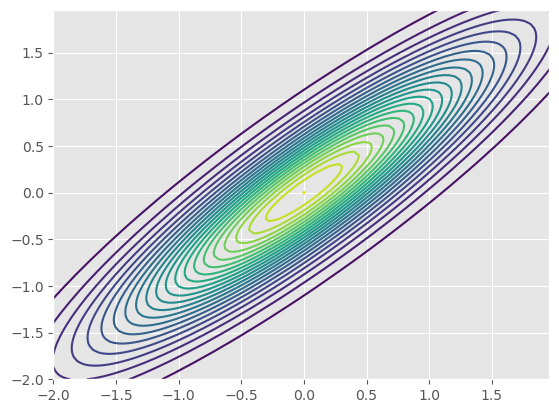

In [78]:
plot_level_lines(mixture, [-2, 2], [-2, 2], './images/mixture')

In [93]:
corr_statistics(mixture)

{20: {'Pearson Corr': '0.41 ± 0.02', 'Spearman Corr': '0.694 ± 0.009'},
 60: {'Pearson Corr': '0.41 ± 0.02', 'Spearman Corr': '0.694 ± 0.009'},
 100: {'Pearson Corr': '0.41 ± 0.02', 'Spearman Corr': '0.694 ± 0.009'}}